## Метод K-ближайших соседов  
### Для базе данных "winequality-white"
Выполнено:
    Лавриченко О.
    Дунаева О.
    Пластинин В.


### I Подготовка данных

Импортируем все требуемые библиотеки:

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
import os
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

Самое важное установить зерно рандома

In [2]:
np.random.seed(32)

#### Посмотрим данные:

In [3]:
df = pd.read_csv("winequality-white.csv", sep=";")

In [4]:
y=df["quality"]
df=df.drop("quality", axis=1)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9


In [5]:
def sum_value(df):
    for i in df.columns.values:
        print(i)
        print(df[i].value_counts())
        print(df[i].isna().sum())
        print("______________________________________")
sum_value(df)

fixed acidity
6.80     308
6.60     290
6.40     280
6.90     241
6.70     236
        ... 
6.45       1
3.80       1
14.20      1
10.20      1
3.90       1
Name: fixed acidity, Length: 68, dtype: int64
0
______________________________________
volatile acidity
0.280    263
0.240    253
0.260    240
0.250    231
0.220    229
        ... 
0.355      1
0.215      1
0.740      1
0.090      1
0.405      1
Name: volatile acidity, Length: 125, dtype: int64
0
______________________________________
citric acid
0.30    307
0.28    282
0.32    257
0.34    225
0.29    223
       ... 
1.66      1
0.11      1
0.86      1
0.99      1
1.23      1
Name: citric acid, Length: 87, dtype: int64
0
______________________________________
residual sugar
1.20     187
1.40     184
1.60     165
1.30     147
1.10     146
        ... 
12.75      1
6.55       1
8.55       1
5.55       1
7.85       1
Name: residual sugar, Length: 310, dtype: int64
0
______________________________________
chlorides
0.044    201
0.036 

Пропусков нет - супер! 
#### Нормализация данных 


In [6]:
def normalization(df, column, minim, maxim):
    X_std = (df[column] - minim) / (maxim - minim)
    return X_std

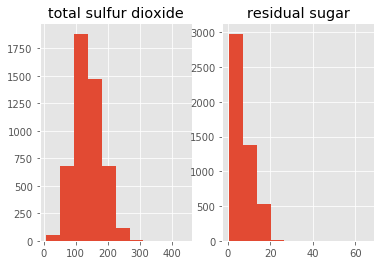

In [7]:
fig, ax = plt.subplots(1, 2)
ax[0].set_title('total sulfur dioxide')
ax[0].hist(df["total sulfur dioxide"])
ax[1].hist(df["residual sugar"])
ax[1].set_title("residual sugar")
plt.show()


In [8]:
for _ in df.columns:
    df[_]=normalization(df, _, df[_].min(), df[_].max())
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.307692,0.186275,0.216867,0.308282,0.106825,0.149826,0.373550,0.267785,0.254545,0.267442,0.129032
1,0.240385,0.215686,0.204819,0.015337,0.118694,0.041812,0.285383,0.132832,0.527273,0.313953,0.241935
2,0.413462,0.196078,0.240964,0.096626,0.121662,0.097561,0.204176,0.154039,0.490909,0.255814,0.338710
3,0.326923,0.147059,0.192771,0.121166,0.145401,0.156794,0.410673,0.163678,0.427273,0.209302,0.306452
4,0.326923,0.147059,0.192771,0.121166,0.145401,0.156794,0.410673,0.163678,0.427273,0.209302,0.306452


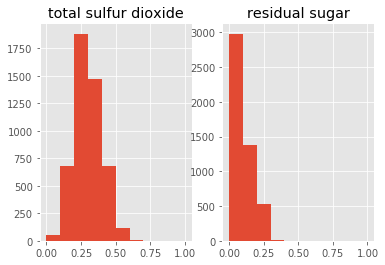

In [9]:
fig, ax = plt.subplots(1, 2)
ax[0].set_title('total sulfur dioxide')
ax[0].hist(df["total sulfur dioxide"])
ax[1].hist(df["residual sugar"])
ax[1].set_title("residual sugar")
plt.show()



Итого все данные приведены к интервалу [0;1]

#### Попытаемся найти выбросы. 
Определим с помощью "ящика с усами"

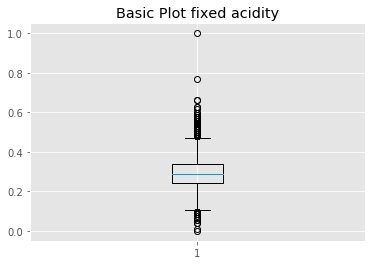

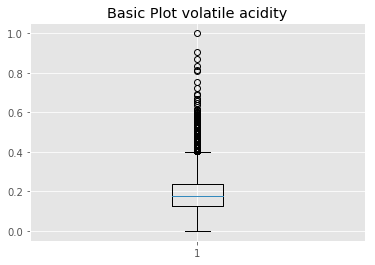

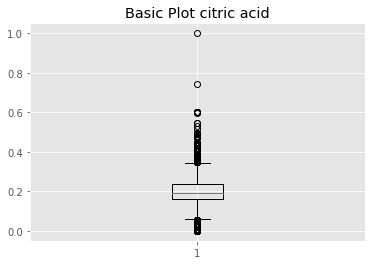

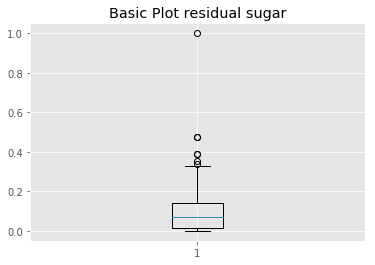

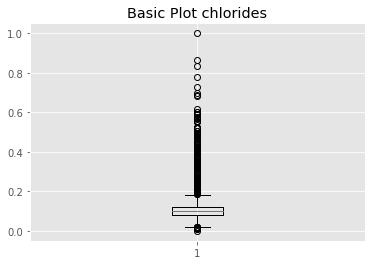

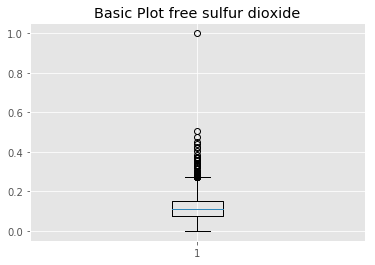

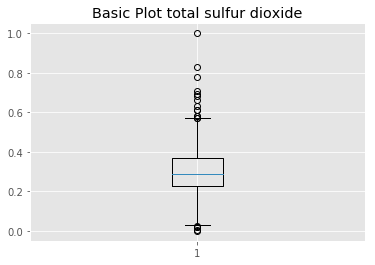

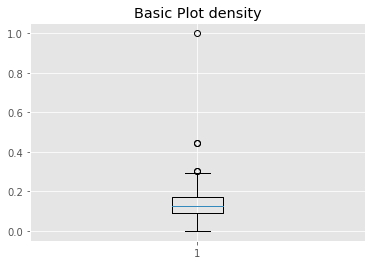

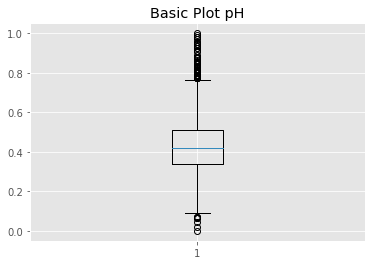

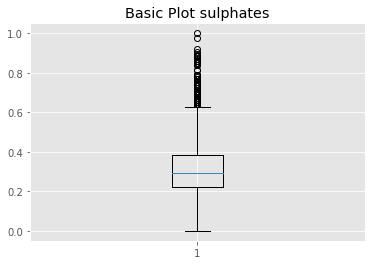

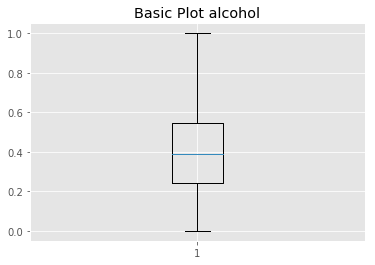

In [10]:
for _ in df.columns:
    fig, ax = plt.subplots()
    ax.set_title('Basic Plot '+_)
    ax.boxplot(df[_])
    plt.show()

### II Настройка модели 

#### Отбор фичей 

In [11]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.307692,0.186275,0.216867,0.308282,0.106825,0.149826,0.373550,0.267785,0.254545,0.267442,0.129032
1,0.240385,0.215686,0.204819,0.015337,0.118694,0.041812,0.285383,0.132832,0.527273,0.313953,0.241935
2,0.413462,0.196078,0.240964,0.096626,0.121662,0.097561,0.204176,0.154039,0.490909,0.255814,0.338710
3,0.326923,0.147059,0.192771,0.121166,0.145401,0.156794,0.410673,0.163678,0.427273,0.209302,0.306452
4,0.326923,0.147059,0.192771,0.121166,0.145401,0.156794,0.410673,0.163678,0.427273,0.209302,0.306452


Для отбора фичей будем использовать метод Лассо, это очень важно в случае KNN,  потому что есть "проклятье размерности"

In [12]:
clf = LassoCV()
sfm = SelectFromModel(clf, threshold=0.1)

In [13]:
sfm.fit(df,y)

/Users/olgalavricenko/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold=0.1)

In [14]:
dfnew=sfm.transform(df)
print(dfnew)

[[0.30769231 0.18627451 0.30828221 ... 0.25454545 0.26744186 0.12903226]
 [0.24038462 0.21568627 0.01533742 ... 0.52727273 0.31395349 0.24193548]
 [0.41346154 0.19607843 0.09662577 ... 0.49090909 0.25581395 0.33870968]
 ...
 [0.25961538 0.15686275 0.00920245 ... 0.24545455 0.27906977 0.22580645]
 [0.16346154 0.20588235 0.00766871 ... 0.56363636 0.18604651 0.77419355]
 [0.21153846 0.12745098 0.00306748 ... 0.49090909 0.11627907 0.61290323]]


#### Подготовка обучающей и тестирующей выборки 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    df,
    y,
    test_size=0.1,
    random_state=32)


### III Настройка модели 

In [16]:
def plot(y_arr,x_arr, ylabel, xlabel,fun=1):
  
    plt.figure()
    if (fun>1):
        for i in range(y_arr.shape[0]):
            plt.plot( x_arr,y_arr[i], color[i])
    else:
        plt.plot(x_arr,y_arr,'k')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()


In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [18]:
cl=[]
au=[]
X_train, X_test, y_train, y_test = train_test_split(dfnew, y, test_size=0.1, random_state=32)
for i in range(10,100,5):
    cl.append(i)
    model = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree', metric='euclidean')
    model.fit(X_train, y_train) 
    au.append(accuracy_score(y_test,model.predict(X_test) )) 


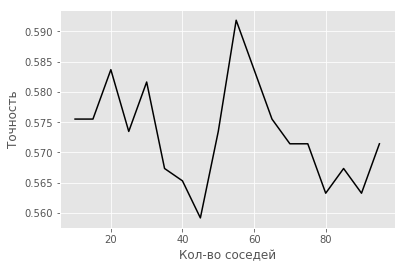

In [19]:
plot(au,cl,"Точность", "Кол-во соседей")

Заметим 35 соседа дают оптимальную точность

#### Подсчет точности

In [20]:
model = KNeighborsClassifier(n_neighbors=55, algorithm='kd_tree', metric='euclidean')
model.fit(X_train, y_train) 

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=55, p=2,
           weights='uniform')

In [21]:
y_pred_test=model.predict(X_test)
y_pred_train=model.predict(X_train)
Accuracy=accuracy_score(y_test,y_pred_test)
print(Accuracy)

0.5918367346938775


Осталось дело в подсчете устойчивости модели + статистические оценки точности 


In [22]:
from sklearn.metrics import classification_report, confusion_matrix  


print(confusion_matrix(y_train, y_pred_train))  
print(classification_report(y_train, y_pred_train)) 
print(confusion_matrix(y_test, y_pred_test))  
print(classification_report(y_test, y_pred_test))  

[[   0    0    7    8    0    0    0]
 [   0    0   84   62    2    0    0]
 [   0    0  774  527   20    0    0]
 [   0    0  384 1439  142    0    0]
 [   0    0   17  524  255    0    0]
 [   0    0    1   99   58    0    0]
 [   0    0    0    2    3    0    0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00       148
           5       0.61      0.59      0.60      1321
           6       0.54      0.73      0.62      1965
           7       0.53      0.32      0.40       796
           8       0.00      0.00      0.00       158
           9       0.00      0.00      0.00         5

   micro avg       0.56      0.56      0.56      4408
   macro avg       0.24      0.23      0.23      4408
weighted avg       0.52      0.56      0.53      4408

[[  0   0   2   3   0   0]
 [  0   0   9   6   0   0]
 [  0   0  78  56   2   0]
 [  0   0  45 173  15   0]
 [  0   0   3  42  39   0]
 

/Users/olgalavricenko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Оценка качества модели

In [23]:
aucs=[]
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(dfnew, y, test_size=0.1, random_state=32)

    model = KNeighborsClassifier(n_neighbors=55, algorithm='kd_tree', metric='euclidean')
    model.fit(X_train, y_train) 
    aucs.append(accuracy_score(y_test,model.predict(X_test) )) 
print( np.mean(aucs), np.std(aucs))

0.5918367346938777 1.1102230246251565e-16


Вывод: метод устойчив, так как разброс не значителен